## Import Packages

In [1]:
from spo.data import shortestpath, dataset
from spo.model import shortestPathModel
from spo.func import SPOPlus
from spo.eval import unambSPO

In [2]:
import time
import math
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import torch
from torch import nn
from torch.utils.data import DataLoader

In [ ]:
torch.manual_seed(135)

## Build Model 

In [3]:
# model for shortest path
grid = (5,5)
sp_model = shortestPathModel(grid)

Academic license - for non-commercial use only - expires 2021-06-13
Using license file C:\Users\Apocrypse\gurobi.lic


## Training

In [4]:
# build linear model
class LinearRegression(nn.Module):
    
    def __init__(self):
        super(LinearRegression, self).__init__()
        self.linear = nn.Linear(p, (grid[0] - 1) * grid[1] + (grid[1] - 1) * grid[0])
    
    def forward(self, x):
        out = self.linear(x)
        return out

In [5]:
def train(dataloader, opt_model, num_epochs, learning_rate, l1_lambda=1e-3):
    """
    train model with SPO+ Loss
    args:
      dataloader: dataloader from optDataSet
      model: optModel
      num_epochs: number of epochs
      l2_lambda: l2 regularization parameter
    """
    print('Training...')
    # init model
    lr = LinearRegression()
    # cuda
    if torch.cuda.is_available():
        lr = lr.cuda()
    # training mode
    lr.train()
    # set optimizer
    optimizer = torch.optim.SGD(lr.parameters(), lr=learning_rate)
    # set SPO+ Loss as criterion
    criterion = SPOPlus()
    # train
    time.sleep(1)
    for epoch in tqdm(range(num_epochs)):
        # load data
        for i, data in enumerate(dataloader):
            x, c, w, z = data
            # cuda
            if torch.cuda.is_available():
                x, c, w, z = x.cuda(), c.cuda(), w.cuda(), z.cuda()
            # forward pass
            cp = lr(x)
            loss = criterion.apply(opt_model, cp, c, w, z).mean()
            # l1 reg
            l1_reg = torch.abs(cp - c).sum(dim=1).mean()
            loss += l1_lambda * l1_reg
            # backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
    return lr

## Experiments

### Training Set Size = 100, Noise Half−width = 0

In [6]:
# set up
n = 100 # number of data
p = 5 # size of feature
e = 0 # noise half−width
degs = [1, 2, 4, 6] # list of param deg

In [7]:
# init DataFrame
df1 = pd.DataFrame(columns = degs)

In [8]:
for i in range(8):
    row = {}
    for deg in degs:
        # generate data
        x, c = shortestpath.genData(n+1000, p, grid, deg=deg, noise_width=e, seed=i)
        # data split
        x_train, x_test, c_train, c_test = train_test_split(x, c, test_size=1000, random_state=i)
        # build data set
        sp_dataset_train = dataset.optDataset(sp_model, x_train, c_train)
        sp_dataset_test = dataset.optDataset(sp_model, x_test, c_test)
        # get data loader
        batch_size = 32
        sp_loader_train = DataLoader(sp_dataset_train, batch_size=batch_size, shuffle=True)
        sp_loader_test = DataLoader(sp_dataset_test, batch_size=batch_size, shuffle=False)
        # train
        learning_rate = 1e-2 * (3 ** deg + 1)
        num_epochs = 1000
        lr = train(sp_loader_train, sp_model, num_epochs=num_epochs, learning_rate=learning_rate, l1_lambda=1e-3)
        # eval
        loss = unambSPO(lr, sp_model, sp_loader_test)
        print('Normalized SPO Loss: {:.2f}%'.format(loss * 100))
        row[deg] = loss
        print()
    df1 = df1.append(row, ignore_index = True)

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 292.33it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 256.08it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████| 1000/1000 [05:05<00:00,  3.28it/s]


Normalized SPO Loss: 0.11%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 365.94it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 305.02it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████| 1000/1000 [06:13<00:00,  2.68it/s]


Normalized SPO Loss: 0.18%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 258.65it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:04<00:00, 223.86it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████| 1000/1000 [06:15<00:00,  2.66it/s]


Normalized SPO Loss: 0.91%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 417.73it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 369.77it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████| 1000/1000 [05:39<00:00,  2.94it/s]


Normalized SPO Loss: 4.44%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 410.93it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 289.83it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████| 1000/1000 [06:12<00:00,  2.69it/s]


Normalized SPO Loss: 0.23%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 368.40it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 311.30it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████| 1000/1000 [05:30<00:00,  3.03it/s]


Normalized SPO Loss: 0.20%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 484.38it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 305.25it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████| 1000/1000 [04:59<00:00,  3.34it/s]


Normalized SPO Loss: 1.16%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 269.57it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 328.65it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████| 1000/1000 [05:16<00:00,  3.15it/s]


Normalized SPO Loss: 5.10%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 326.61it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 342.10it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████| 1000/1000 [05:08<00:00,  3.24it/s]


Normalized SPO Loss: 0.25%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 430.27it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 379.34it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████| 1000/1000 [05:36<00:00,  2.97it/s]


Normalized SPO Loss: 0.32%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 354.22it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 306.29it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████| 1000/1000 [05:08<00:00,  3.25it/s]


Normalized SPO Loss: 1.81%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 316.29it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 319.39it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████| 1000/1000 [05:05<00:00,  3.27it/s]


Normalized SPO Loss: 6.02%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 358.96it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 373.62it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████| 1000/1000 [05:10<00:00,  3.22it/s]


Normalized SPO Loss: 0.20%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 428.50it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 358.27it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████| 1000/1000 [05:00<00:00,  3.33it/s]


Normalized SPO Loss: 0.36%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 383.42it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 379.92it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████| 1000/1000 [05:06<00:00,  3.27it/s]


Normalized SPO Loss: 2.02%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 335.57it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 314.93it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████| 1000/1000 [05:11<00:00,  3.21it/s]


Normalized SPO Loss: 6.75%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 344.98it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 372.17it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████| 1000/1000 [05:05<00:00,  3.28it/s]


Normalized SPO Loss: 0.14%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 369.99it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 430.92it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████| 1000/1000 [05:03<00:00,  3.29it/s]


Normalized SPO Loss: 0.23%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 253.92it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.04it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████| 1000/1000 [05:24<00:00,  3.08it/s]


Normalized SPO Loss: 1.33%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 453.70it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 449.34it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████| 1000/1000 [04:20<00:00,  3.84it/s]


Normalized SPO Loss: 4.16%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 430.28it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 415.41it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████| 1000/1000 [04:15<00:00,  3.92it/s]


Normalized SPO Loss: 0.14%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 486.78it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 433.34it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████| 1000/1000 [04:22<00:00,  3.81it/s]


Normalized SPO Loss: 0.52%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 396.32it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 447.91it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████| 1000/1000 [04:13<00:00,  3.95it/s]


Normalized SPO Loss: 2.31%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 421.24it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 442.26it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████| 1000/1000 [04:19<00:00,  3.85it/s]


Normalized SPO Loss: 7.97%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 498.84it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 435.67it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████| 1000/1000 [04:18<00:00,  3.87it/s]


Normalized SPO Loss: 0.11%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 359.38it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 373.90it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████| 1000/1000 [04:13<00:00,  3.95it/s]


Normalized SPO Loss: 0.13%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 455.73it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 439.15it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████| 1000/1000 [04:13<00:00,  3.95it/s]


Normalized SPO Loss: 0.87%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 442.42it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 449.11it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████| 1000/1000 [04:14<00:00,  3.93it/s]


Normalized SPO Loss: 2.97%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 380.58it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 446.41it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████| 1000/1000 [04:21<00:00,  3.82it/s]


Normalized SPO Loss: 0.17%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 324.51it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 362.76it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████| 1000/1000 [04:15<00:00,  3.91it/s]


Normalized SPO Loss: 0.32%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 468.54it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 444.55it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████| 1000/1000 [04:18<00:00,  3.86it/s]


Normalized SPO Loss: 1.25%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 278.90it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 387.52it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████| 1000/1000 [04:26<00:00,  3.75it/s]


Normalized SPO Loss: 3.46%



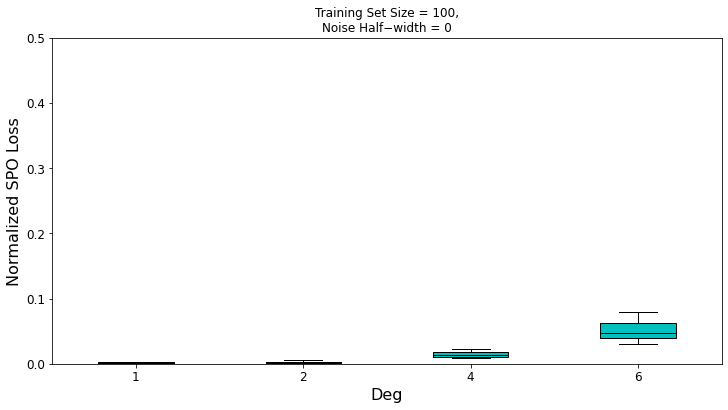

In [9]:
# draw boxplot
plt.figure(figsize=(12,6))
plt.boxplot(df1, boxprops=dict(facecolor='c', color='k'), medianprops=dict(color='k'), patch_artist=True)
plt.xlabel('Deg', fontsize=16)
plt.xticks(ticks=[1,2,3,4], labels=[1,2,4,6], fontsize=12)
plt.ylabel('Normalized SPO Loss', fontsize=16)
plt.yticks(fontsize=12)
plt.ylim(0, 0.5)
plt.title('Training Set Size = 100,\nNoise Half−width = 0')
plt.show()

### Training Set Size = 100, Noise Half−width = 0.5

In [10]:
# set
n = 100 # number of data
p = 5 # size of feature
e = 0.5 # noise half−width
degs = [1, 2, 4, 6] # list of param deg

In [11]:
# init DataFrame
df2 = pd.DataFrame(columns = degs)

In [12]:
for i in range(8):
    row = {}
    for deg in degs:
        # generate data
        x, c = shortestpath.genData(n+1000, p, grid, deg=deg, noise_width=e, seed=i)
        # data split
        x_train, x_test, c_train, c_test = train_test_split(x, c, test_size=1000, random_state=i)
        # build data set
        sp_dataset_train = dataset.optDataset(sp_model, x_train, c_train)
        sp_dataset_test = dataset.optDataset(sp_model, x_test, c_test)
        # get data loader
        batch_size = 32
        sp_loader_train = DataLoader(sp_dataset_train, batch_size=batch_size, shuffle=True)
        sp_loader_test = DataLoader(sp_dataset_test, batch_size=batch_size, shuffle=False)
        # train
        learning_rate = 1e-2 * (3 ** deg + 1)
        num_epochs = 1000
        lr = train(sp_loader_train, sp_model, num_epochs=num_epochs, learning_rate=learning_rate, l1_lambda=1e-3)
        # eval
        loss = unambSPO(lr, sp_model, sp_loader_test)
        print('Normalized SPO Loss: {:.2f}%'.format(loss * 100))
        row[deg] = loss
        print()
    df2 = df2.append(row, ignore_index = True)

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 385.64it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 393.67it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████| 1000/1000 [04:01<00:00,  4.15it/s]


Normalized SPO Loss: 16.94%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 382.70it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 375.39it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████| 1000/1000 [04:00<00:00,  4.16it/s]


Normalized SPO Loss: 11.88%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 484.38it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 459.73it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████| 1000/1000 [04:01<00:00,  4.14it/s]


Normalized SPO Loss: 9.14%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 387.13it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 471.63it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████| 1000/1000 [04:14<00:00,  3.94it/s]


Normalized SPO Loss: 11.08%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 466.32it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 440.16it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████| 1000/1000 [04:07<00:00,  4.04it/s]


Normalized SPO Loss: 17.16%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 455.82it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 445.03it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████| 1000/1000 [04:08<00:00,  4.03it/s]


Normalized SPO Loss: 11.07%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 464.13it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 456.59it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████| 1000/1000 [04:10<00:00,  3.98it/s]


Normalized SPO Loss: 7.79%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 432.19it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 422.00it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████| 1000/1000 [04:10<00:00,  3.99it/s]


Normalized SPO Loss: 8.39%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 470.74it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 461.00it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████| 1000/1000 [04:01<00:00,  4.15it/s]


Normalized SPO Loss: 18.54%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 484.38it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 470.80it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████| 1000/1000 [04:04<00:00,  4.09it/s]


Normalized SPO Loss: 13.68%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 462.09it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 451.05it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████| 1000/1000 [04:01<00:00,  4.15it/s]


Normalized SPO Loss: 11.52%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 432.19it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 423.43it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████| 1000/1000 [04:00<00:00,  4.16it/s]


Normalized SPO Loss: 11.74%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 435.95it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 473.85it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████| 1000/1000 [04:02<00:00,  4.13it/s]


Normalized SPO Loss: 18.86%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 404.30it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 377.51it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████| 1000/1000 [04:34<00:00,  3.64it/s]


Normalized SPO Loss: 13.31%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 406.74it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 448.36it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████| 1000/1000 [04:15<00:00,  3.91it/s]


Normalized SPO Loss: 10.60%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 377.34it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 371.07it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████| 1000/1000 [04:15<00:00,  3.91it/s]


Normalized SPO Loss: 12.37%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 499.96it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 443.48it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████| 1000/1000 [04:20<00:00,  3.84it/s]


Normalized SPO Loss: 19.00%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 449.65it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 438.20it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████| 1000/1000 [04:19<00:00,  3.86it/s]


Normalized SPO Loss: 13.22%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 399.52it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 427.83it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████| 1000/1000 [04:17<00:00,  3.89it/s]


Normalized SPO Loss: 9.41%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 477.46it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 445.48it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████| 1000/1000 [04:16<00:00,  3.91it/s]


Normalized SPO Loss: 10.86%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 400.26it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 366.74it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████| 1000/1000 [04:17<00:00,  3.89it/s]


Normalized SPO Loss: 17.99%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 411.75it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 487.79it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████| 1000/1000 [03:50<00:00,  4.33it/s]


Normalized SPO Loss: 12.47%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 511.58it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 481.62it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████| 1000/1000 [03:59<00:00,  4.17it/s]


Normalized SPO Loss: 10.09%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 489.11it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 484.88it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████| 1000/1000 [03:46<00:00,  4.42it/s]


Normalized SPO Loss: 15.51%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 409.26it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 488.13it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████| 1000/1000 [03:45<00:00,  4.43it/s]


Normalized SPO Loss: 17.49%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 464.11it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 499.77it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████| 1000/1000 [03:47<00:00,  4.41it/s]


Normalized SPO Loss: 12.22%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 519.66it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 482.73it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████| 1000/1000 [03:45<00:00,  4.44it/s]


Normalized SPO Loss: 8.67%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 437.85it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 473.46it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████| 1000/1000 [03:41<00:00,  4.52it/s]


Normalized SPO Loss: 8.84%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 432.14it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 506.66it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████| 1000/1000 [03:39<00:00,  4.57it/s]


Normalized SPO Loss: 17.58%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 435.91it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 483.89it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████| 1000/1000 [03:39<00:00,  4.56it/s]


Normalized SPO Loss: 11.97%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 464.13it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 505.77it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████| 1000/1000 [03:36<00:00,  4.63it/s]


Normalized SPO Loss: 9.35%

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 489.04it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 513.13it/s]


Training...


100%|██████████████████████████████████████████████████████████████████████| 1000/1000 [03:37<00:00,  4.59it/s]


Normalized SPO Loss: 10.75%



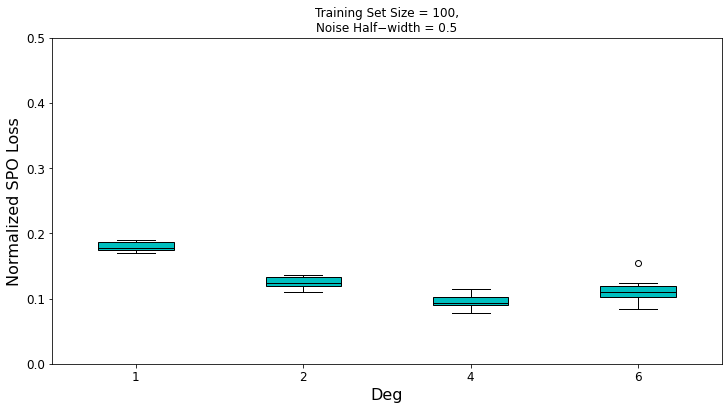

In [13]:
# draw boxplot
plt.figure(figsize=(12,6))
plt.boxplot(df2, boxprops=dict(facecolor='c', color='k'), medianprops=dict(color='k'), patch_artist=True)
plt.xlabel('Deg', fontsize=16)
plt.xticks(ticks=[1,2,3,4], labels=[1,2,4,6], fontsize=12)
plt.ylabel('Normalized SPO Loss', fontsize=16)
plt.yticks(fontsize=12)
plt.ylim(0, 0.5)
plt.title('Training Set Size = 100,\nNoise Half−width = 0.5')
plt.show()

## Training Set Size = 1000, Noise Half−width = 0 

In [14]:
# set
n = 1000 # number of data
p = 5 # size of feature
e = 0 # noise half−width
degs = [1, 2, 4, 6] # list of param deg

In [15]:
# init DataFrame
df3 = pd.DataFrame(columns = degs)

In [16]:
for i in range(8):
    row = {}
    for deg in degs:
        # generate data
        x, c = shortestpath.genData(n+1000, p, grid, deg=deg, noise_width=e, seed=i)
        # data split
        x_train, x_test, c_train, c_test = train_test_split(x, c, test_size=1000, random_state=i)
        # build data set
        sp_dataset_train = dataset.optDataset(sp_model, x_train, c_train)
        sp_dataset_test = dataset.optDataset(sp_model, x_test, c_test)
        # get data loader
        batch_size = 32
        sp_loader_train = DataLoader(sp_dataset_train, batch_size=batch_size, shuffle=True)
        sp_loader_test = DataLoader(sp_dataset_test, batch_size=batch_size, shuffle=False)
        # train
        learning_rate = 1e-2 * (3 ** deg + 1)
        num_epochs = 100
        lr = train(sp_loader_train, sp_model, num_epochs=num_epochs, learning_rate=learning_rate, l1_lambda=1e-3)
        # eval
        loss = unambSPO(lr, sp_model, sp_loader_test)
        print('Normalized SPO Loss: {:.2f}%'.format(loss * 100))
        row[deg] = loss
        print()
    df3 = df3.append(row, ignore_index = True)

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 418.65it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 431.07it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 100/100 [03:42<00:00,  2.22s/it]


Normalized SPO Loss: 0.03%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 459.31it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 447.62it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 100/100 [03:33<00:00,  2.13s/it]


Normalized SPO Loss: 0.06%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 479.52it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 499.10it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 100/100 [03:33<00:00,  2.13s/it]


Normalized SPO Loss: 0.95%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 516.04it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 502.93it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 100/100 [03:31<00:00,  2.12s/it]


Normalized SPO Loss: 4.66%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 513.79it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 497.61it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 100/100 [03:31<00:00,  2.11s/it]


Normalized SPO Loss: 0.01%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 501.58it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 506.74it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 100/100 [03:35<00:00,  2.15s/it]


Normalized SPO Loss: 0.05%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 476.25it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 466.58it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 100/100 [03:35<00:00,  2.15s/it]


Normalized SPO Loss: 0.81%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 499.66it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 513.92it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 100/100 [03:33<00:00,  2.13s/it]


Normalized SPO Loss: 3.26%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 490.08it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 429.30it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 100/100 [03:32<00:00,  2.12s/it]


Normalized SPO Loss: 0.07%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 505.38it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 503.33it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 100/100 [03:32<00:00,  2.12s/it]


Normalized SPO Loss: 0.13%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 508.12it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 498.84it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 100/100 [03:36<00:00,  2.17s/it]


Normalized SPO Loss: 1.44%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 462.27it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 389.84it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 100/100 [03:37<00:00,  2.17s/it]


Normalized SPO Loss: 5.70%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 435.10it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 453.28it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 100/100 [03:31<00:00,  2.12s/it]


Normalized SPO Loss: 0.04%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 511.03it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 491.62it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 100/100 [03:35<00:00,  2.16s/it]


Normalized SPO Loss: 0.06%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 508.97it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 500.04it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 100/100 [03:37<00:00,  2.18s/it]


Normalized SPO Loss: 1.27%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 485.95it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 491.15it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 100/100 [03:34<00:00,  2.14s/it]


Normalized SPO Loss: 5.56%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 502.58it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 519.03it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 100/100 [03:31<00:00,  2.12s/it]


Normalized SPO Loss: 0.02%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 500.84it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 504.84it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 100/100 [03:33<00:00,  2.13s/it]


Normalized SPO Loss: 0.10%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 503.36it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 510.68it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 100/100 [03:36<00:00,  2.17s/it]


Normalized SPO Loss: 1.08%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 508.71it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 495.88it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 100/100 [03:32<00:00,  2.12s/it]


Normalized SPO Loss: 4.15%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 465.71it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 512.73it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 100/100 [03:32<00:00,  2.13s/it]


Normalized SPO Loss: 0.04%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 504.63it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 503.85it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 100/100 [03:32<00:00,  2.12s/it]


Normalized SPO Loss: 0.11%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 461.85it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 462.27it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 100/100 [03:37<00:00,  2.18s/it]


Normalized SPO Loss: 1.56%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 441.70it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 449.23it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 100/100 [03:31<00:00,  2.12s/it]


Normalized SPO Loss: 5.88%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 492.71it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 511.88it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 100/100 [03:32<00:00,  2.12s/it]


Normalized SPO Loss: 0.03%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 501.22it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 504.18it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 100/100 [03:32<00:00,  2.13s/it]


Normalized SPO Loss: 0.06%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 509.84it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 512.90it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 100/100 [03:36<00:00,  2.16s/it]


Normalized SPO Loss: 0.77%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 461.21it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 446.82it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 100/100 [03:34<00:00,  2.14s/it]


Normalized SPO Loss: 3.44%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 501.05it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 507.42it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 100/100 [03:31<00:00,  2.12s/it]


Normalized SPO Loss: 0.05%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 505.64it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 482.19it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 100/100 [03:33<00:00,  2.14s/it]


Normalized SPO Loss: 0.07%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 490.58it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 502.34it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 100/100 [03:34<00:00,  2.14s/it]


Normalized SPO Loss: 1.03%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 505.99it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 504.37it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 100/100 [03:44<00:00,  2.24s/it]


Normalized SPO Loss: 4.31%



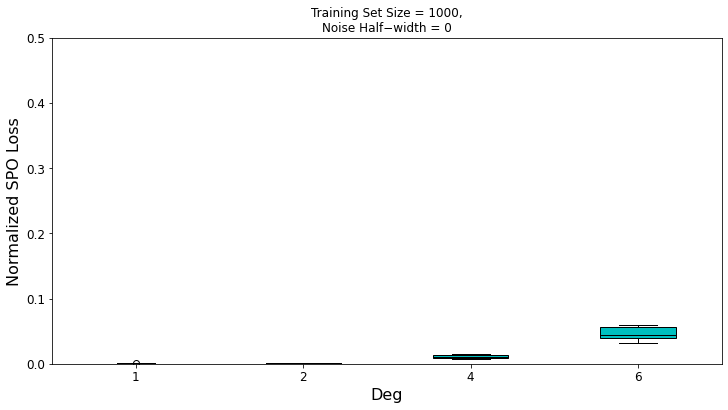

In [17]:
# draw boxplot
plt.figure(figsize=(12,6))
plt.boxplot(df3, boxprops=dict(facecolor='c', color='k'), medianprops=dict(color='k'), patch_artist=True)
plt.xlabel('Deg', fontsize=16)
plt.xticks(ticks=[1,2,3,4], labels=[1,2,4,6], fontsize=12)
plt.ylabel('Normalized SPO Loss', fontsize=16)
plt.yticks(fontsize=12)
plt.ylim(0, 0.5)
plt.title('Training Set Size = 1000,\nNoise Half−width = 0')
plt.show()

## Training Set Size = 1000, Noise Half−width = 0.5 

In [18]:
# set
n = 1000 # number of data
p = 5 # size of feature
e = 0.5 # noise half−width
degs = [1, 2, 4, 6] # list of param deg

In [19]:
# init DataFrame
df4 = pd.DataFrame(columns = degs)

In [20]:
for i in range(8):
    row = {}
    for deg in degs:
        # generate data
        x, c = shortestpath.genData(n+1000, p, grid, deg=deg, noise_width=e, seed=i)
        # data split
        x_train, x_test, c_train, c_test = train_test_split(x, c, test_size=1000, random_state=i)
        # build data set
        sp_dataset_train = dataset.optDataset(sp_model, x_train, c_train)
        sp_dataset_test = dataset.optDataset(sp_model, x_test, c_test)
        # get data loader
        batch_size = 32
        sp_loader_train = DataLoader(sp_dataset_train, batch_size=batch_size, shuffle=True)
        sp_loader_test = DataLoader(sp_dataset_test, batch_size=batch_size, shuffle=False)
        # train
        learning_rate = 1e-2 * (3 ** deg + 1)
        num_epochs = 100
        lr = train(sp_loader_train, sp_model, num_epochs=num_epochs, learning_rate=learning_rate, l1_lambda=1e-3)
        # eval
        loss = unambSPO(lr, sp_model, sp_loader_test)
        print('Normalized SPO Loss: {:.2f}%'.format(loss * 100))
        row[deg] = loss
        print()
    df4 = df4.append(row, ignore_index = True)

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 456.58it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 491.66it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 100/100 [03:56<00:00,  2.36s/it]


Normalized SPO Loss: 16.27%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 493.39it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 471.71it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 100/100 [03:46<00:00,  2.27s/it]


Normalized SPO Loss: 10.86%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 451.18it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 459.90it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 100/100 [03:48<00:00,  2.29s/it]


Normalized SPO Loss: 8.13%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 468.52it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 451.16it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 100/100 [03:47<00:00,  2.28s/it]


Normalized SPO Loss: 11.97%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 478.87it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 453.53it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 100/100 [03:56<00:00,  2.36s/it]


Normalized SPO Loss: 15.42%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 442.67it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 402.35it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 100/100 [03:58<00:00,  2.38s/it]


Normalized SPO Loss: 9.70%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 408.02it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 416.49it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 100/100 [04:17<00:00,  2.57s/it]


Normalized SPO Loss: 6.76%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 470.63it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 469.81it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 100/100 [04:39<00:00,  2.80s/it]


Normalized SPO Loss: 8.32%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 427.38it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 430.98it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 100/100 [04:04<00:00,  2.44s/it]


Normalized SPO Loss: 16.46%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 332.81it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 321.98it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 100/100 [04:43<00:00,  2.83s/it]


Normalized SPO Loss: 12.28%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 432.35it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 417.20it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 100/100 [04:16<00:00,  2.56s/it]


Normalized SPO Loss: 9.86%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 424.39it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 448.95it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 100/100 [03:57<00:00,  2.38s/it]


Normalized SPO Loss: 12.37%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 489.48it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 491.03it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 100/100 [03:42<00:00,  2.23s/it]


Normalized SPO Loss: 16.05%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 494.27it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 494.21it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 100/100 [04:24<00:00,  2.64s/it]


Normalized SPO Loss: 11.12%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 412.72it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 420.94it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 100/100 [04:24<00:00,  2.64s/it]


Normalized SPO Loss: 8.50%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 356.77it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 400.97it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 100/100 [04:27<00:00,  2.67s/it]


Normalized SPO Loss: 11.63%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 359.60it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 322.31it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 100/100 [04:25<00:00,  2.66s/it]


Normalized SPO Loss: 17.18%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 421.99it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 418.05it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 100/100 [04:08<00:00,  2.49s/it]


Normalized SPO Loss: 11.84%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 365.09it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 331.70it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 100/100 [04:23<00:00,  2.64s/it]


Normalized SPO Loss: 9.26%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 424.22it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 415.18it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 100/100 [04:22<00:00,  2.62s/it]


Normalized SPO Loss: 11.12%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 450.09it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 409.33it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 100/100 [04:25<00:00,  2.65s/it]


Normalized SPO Loss: 16.49%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 293.51it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 340.49it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 100/100 [03:56<00:00,  2.36s/it]


Normalized SPO Loss: 11.53%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 488.61it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 487.33it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 100/100 [04:16<00:00,  2.57s/it]


Normalized SPO Loss: 9.22%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 367.93it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 342.86it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 100/100 [04:19<00:00,  2.59s/it]


Normalized SPO Loss: 13.42%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 404.52it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 419.38it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 100/100 [04:25<00:00,  2.65s/it]


Normalized SPO Loss: 16.09%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 374.33it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 381.64it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 100/100 [04:33<00:00,  2.74s/it]


Normalized SPO Loss: 10.88%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 315.33it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 317.26it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 100/100 [05:24<00:00,  3.25s/it]


Normalized SPO Loss: 8.03%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 324.20it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 313.36it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 100/100 [05:15<00:00,  3.16s/it]


Normalized SPO Loss: 9.17%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 323.42it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 336.20it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 100/100 [05:32<00:00,  3.32s/it]


Normalized SPO Loss: 15.65%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 166.58it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:05<00:00, 174.69it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 100/100 [05:48<00:00,  3.48s/it]


Normalized SPO Loss: 9.88%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 332.88it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 327.70it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 100/100 [05:10<00:00,  3.11s/it]


Normalized SPO Loss: 7.19%

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 325.19it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 327.09it/s]


Training...


100%|████████████████████████████████████████████████████████████████████████| 100/100 [04:43<00:00,  2.83s/it]


Normalized SPO Loss: 8.69%



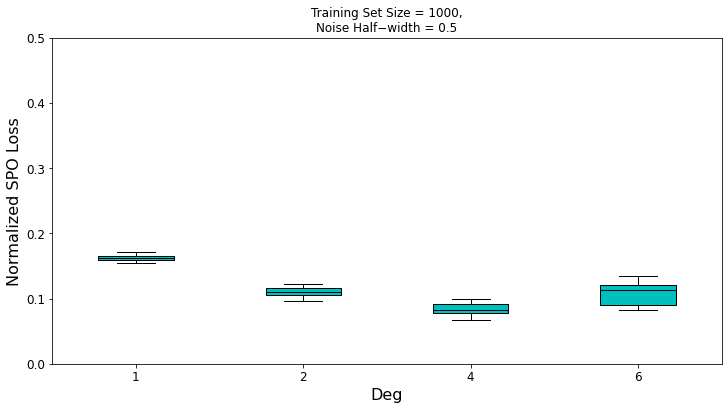

In [21]:
# draw boxplot
plt.figure(figsize=(12,6))
plt.boxplot(df4, boxprops=dict(facecolor='c', color='k'), medianprops=dict(color='k'), patch_artist=True)
plt.xlabel('Deg', fontsize=16)
plt.xticks(ticks=[1,2,3,4], labels=[1,2,4,6], fontsize=12)
plt.ylabel('Normalized SPO Loss', fontsize=16)
plt.yticks(fontsize=12)
plt.ylim(0, 0.5)
plt.title('Training Set Size = 1000,\nNoise Half−width = 0.5')
plt.show()

## Save File 

In [22]:
df1.to_csv('./res/spoplus_n100.csv', index=False)
df2.to_csv('./res/spoplus_n100_noise.csv', index=False)
df3.to_csv('./res/spoplus_n1000.csv', index=False)
df4.to_csv('./res/spoplus_n1000_noise.csv', index=False)